## Import Thư viện

In [4]:
import pandas as pd
from category_encoders import BinaryEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,accuracy_score,accuracy_score,recall_score,f1_score,precision_score,confusion_matrix
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import Normalizer, MinMaxScaler, RobustScaler, StandardScaler, MaxAbsScaler, \
    PowerTransformer, QuantileTransformer,LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud as WordCloud
import numpy as np
from collections import Counter
from datetime import datetime
from scipy.stats import uniform

import warnings
warnings.filterwarnings('ignore')

## Mã hóa dữ liệu

In [5]:
def binary_encoder(df, var , list):
    for i in list[var]:
        new_data=[]
        for j in df[var]:
            new_data.append(1 if i in j else 0)
        df[var+'_'+i]=new_data
    df.drop(columns=var)
    return df


In [6]:
def label_encoder(df, var):
    label_encoder = LabelEncoder()
    df[var] = label_encoder.fit_transform(df[var])
    return df

## Xử lí dữ liệu trống

In [7]:
def ms_mode(X_train, X_test, var):
    # Điền giá trị xuất hiện nhiều nhất vào các ô trống (Model Imputation)
    most_common = X_train[var].mode()[0]
    X_train[var] = X_train[var].fillna(most_common)
    X_test[var] = X_test[var].fillna(most_common)
    return X_train, X_test

## Xử lí kí tự đặc biệt

In [8]:


def split_string_office(data,var):
    data[var]=[int(rt.replace('$','').replace(',','')) if rt is not np.nan else np.nan for rt in data[var]]
    return data


In [9]:


def split_string_time(data):
    data['Running Time']=[int(rt.split(' ')[0]) if rt is not np.nan else np.nan for rt in data['Running Time']]
    return data

In [10]:
def date(x):
    x=str(x)
    date_string=x.replace('th,','').replace('st,','').replace('nd,','').replace('rd,','').replace(' ','')
    try:
        date_obj=datetime.strptime(date_string,'%B%d%Y')
    except ValueError:
        date_obj=np.nan
    return date_obj

def split_string_date(data):
    data['Day Releases']=data['Date Releases'].apply(lambda x: date(x).weekday() if x is not np.nan and date(x) is not np.nan else np.nan)
    data['Month Releases']=data['Date Releases'].apply(lambda x: date(x).month if x is not np.nan and date(x) is not np.nan else np.nan)
    
    return data



## Xử lí ngoại lệ

In [11]:

def handler_outlier(df_train, df_test, var):
    q1, q3 = np.percentile(df_train[var], [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)

    df_train[var] = df_train[var].clip(lower_bound, upper_bound)
    df_test[var] = df_test[var].clip(lower_bound, upper_bound)
    
    return df_train, df_test

## Chuẩn hóa dữ liệu

In [12]:
def minmax_scaler(df):
    new_df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns, index=df.index)
    return new_df

In [13]:
def robust_scaler(df):
    new_df = pd.DataFrame(RobustScaler(quantile_range=(25, 75)).fit_transform(df), columns=df.columns, index=df.index)
    return new_df


In [14]:
def standard_scaler(df):
    new_df = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns, index=df.index)
    return new_df


In [15]:
def maxabs_scaler(df):
    new_df = pd.DataFrame(MaxAbsScaler().fit_transform(df), columns=df.columns, index=df.index)
    return new_df


In [16]:
def power_transformer(df):
    new_df = pd.DataFrame(PowerTransformer(method='yeo-johnson').fit_transform(df), columns=df.columns, index=df.index)
    return new_df


In [17]:
def quantile_transformer(df):
    new_df = pd.DataFrame(QuantileTransformer(n_quantiles=len(df), output_distribution='normal').fit_transform(df))
    return new_df


In [18]:
def normalizer(df):
    new_df = pd.DataFrame(Normalizer().fit_transform(df), columns=df.columns, index=df.index)
    return new_df


In [19]:
def normal_data(X_train, X_test, type):
    if type == 'Unscaled':
        pass
    elif type == 'Standard':
        X_train = standard_scaler(X_train)
        X_test = standard_scaler(X_test)
    elif type == 'MinMax':
        X_train = minmax_scaler(X_train)
        X_test = minmax_scaler(X_test)
    elif type == 'MaxAbs':
        X_train = maxabs_scaler(X_train)
        X_test = maxabs_scaler(X_test)
    elif type == 'Robust':
        X_train = robust_scaler(X_train)
        X_test = robust_scaler(X_test)
    elif type == 'PowerTransformer':
        X_train = power_transformer(X_train)
        X_test = power_transformer(X_test)
    elif type == 'QuantileTransformer':
        X_train = quantile_transformer(X_train)
        X_test = quantile_transformer(X_test)
    elif type == 'Normalizer':
        X_train = normalizer(X_train)
        X_test = normalizer(X_test)
    return X_train, X_test

## Main

In [20]:
bigDS_path = 'raw_data/BigDS_raw.csv'

df_big = pd.read_csv(bigDS_path)

df_big.head()

,Unnamed: 0,Rank,Year,Movie,WorldwideBox Office,Production Budget,Date Releases,MPAA,Running Time,Franchise,Genre,Creative Type,Production/Financing Companies,Production Countries,Languages,Director
0,0,1,2009,Avatar,"$2,923,706,026","$237,000,000","December 17th, 2009",PG-13,162 minutes,Avatar,Action,Science Fiction,"Dune Entertainment, 20th Century Fox, Ingeniou...",United States,"English, Na'vi",James Cameron
1,1,2,2019,Avengers-Endgame-(2019),"$2,794,731,755","$400,000,000","April 23rd, 2019",PG-13,181 minutes,Marvel Cinematic UniverseAvengers,Action,Super Hero,Marvel Studios,United States,English,"Joe Russo,Anthony Russo"
2,2,3,2022,Avatar-The-Way-of-Water-(2022),"$2,319,739,969","$460,000,000","December 9th, 2022",PG-13,190 minutes,Avatar,Action,Science Fiction,"Lightstorm Entertainment, 20th Century Studios...",United States,English,James Cameron
3,3,4,1997,Titanic-(1997),"$2,222,985,568","$200,000,000","December 18th, 1997",PG-13,194 minutes,NaN,Drama,Historical Fiction,"20th Century Fox, Paramount Pictures, Lightsto...",United States,"English, Italian, Swedish",James Cameron
4,4,5,2015,Star-Wars-Ep-VII-The-Force-Awakens,"$2,064,615,817","$306,000,000","December 16th, 2015",PG-13,136 minutes,Star Wars,Adventure,Science Fiction,"Lucasfilm, Bad Robot",United States,English,J.J. Abrams


In [21]:

data = df_big.copy()

split_string_office(data,'WorldwideBox Office')
split_string_office(data,'Production Budget')
split_string_time(data)
split_string_date(data)

data.to_csv('clean_data/BigDS_clean.csv')

# data.info()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      10000 non-null  int64  
 1   Rank                            10000 non-null  int64  
 2   Year                            10000 non-null  int64  
 3   Movie                           10000 non-null  object 
 4   WorldwideBox Office             10000 non-null  int64  
 5   Production Budget               4707 non-null   float64
 6   Date Releases                   5290 non-null   object 
 7   MPAA                            7490 non-null   object 
 8   Running Time                    8569 non-null   float64
 9   Franchise                       1964 non-null   object 
 10  Genre                           9511 non-null   object 
 11  Creative Type                   9261 non-null   object 
 12  Production/Financing Companies  4

## Trực quan hóa đặc trưng của dữ liệu

### Trực quan hóa dữ liệu các đặc trưng có dữ liệu trống

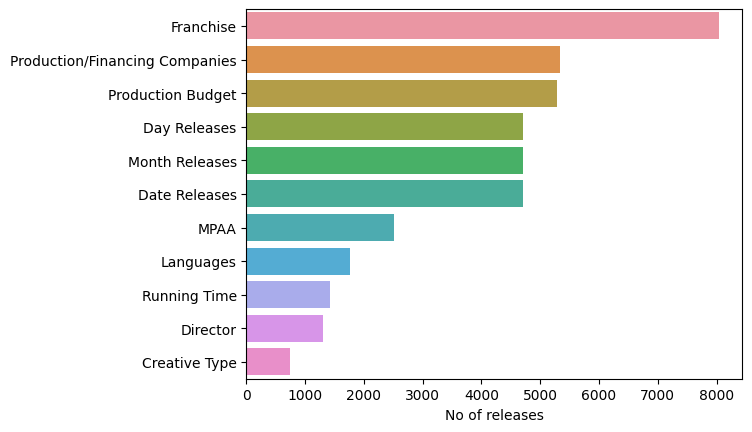

In [22]:
# plt.figure(figsize=(10,10))
missing=data.isna().sum().sort_values(ascending=False)
sns.barplot(x=missing[:11],y=missing[:11].index)
plt.style.use('dark_background')
plt.xlabel('No of releases')
plt.show()

### Trực quan hóa dữ liệu các series phim có nhiều phần

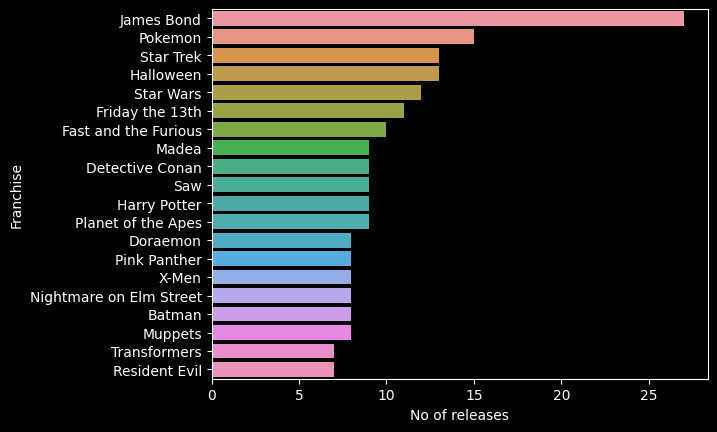

In [23]:
list_franchise=data.groupby(['Franchise']).size().reset_index(name='No of releases').sort_values(ascending=False,by='No of releases')
sns.barplot(data=list_franchise[:20],y='Franchise',x='No of releases')
plt.show()

### Trực quan hóa số lượng các bộ phim của các công ty/nhà sản xuất 

<Axes: xlabel='No of releases', ylabel='Production/Financing Companies'>

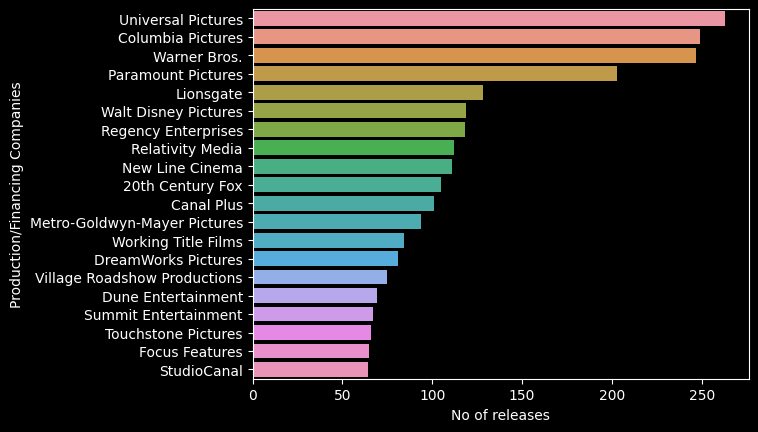

In [24]:
data['Production/Financing Companies']=data['Production/Financing Companies'].apply(lambda x:[i for i in x.split(', ')] if x is not np.nan else [] )
list_companies=pd.DataFrame(Counter([i for j in data['Production/Financing Companies'] for i in j]).most_common(),columns=['Production/Financing Companies','No of releases'])
sns.barplot(data=list_companies[:20],y='Production/Financing Companies',x='No of releases')

### Trực quan hóa số lượng phim của các quốc gia

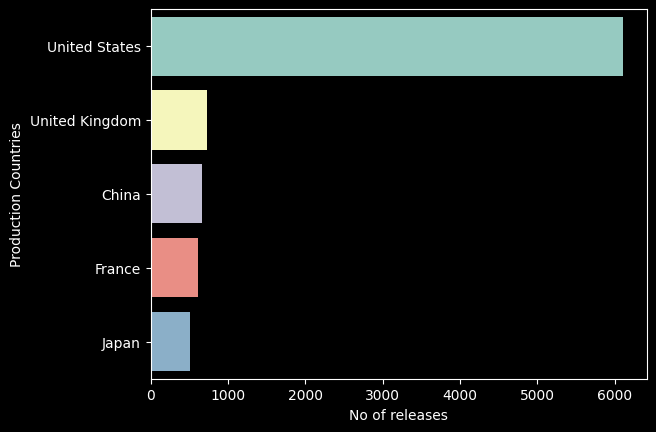

In [25]:
data['Production Countries']=data['Production Countries'].apply(lambda x:[i for i in x.split(', ')] if x is not np.nan else [] )
list_countries=pd.DataFrame(Counter([i for j in data['Production Countries'] for i in j]).most_common(),columns=['Production Countries','No of releases'])
sns.barplot(data=list_countries[:5],y='Production Countries',x='No of releases')
plt.show()

### Trực quan hóa dữ liệu xem số lượng phim sử dụng ngôn ngữ nào và bao nhiêu

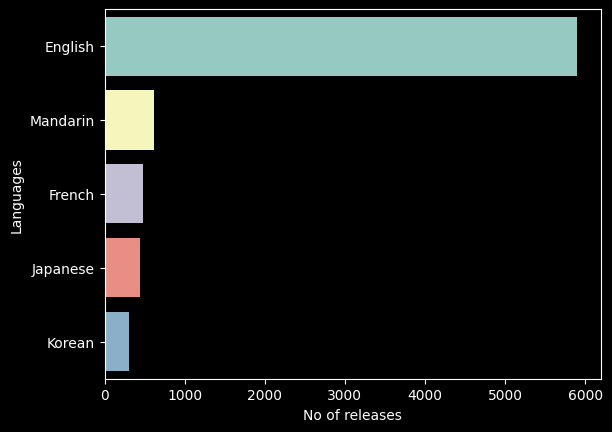

In [26]:
data['Languages']=data['Languages'].apply(lambda x:[i for i in x.split(', ')] if x is not np.nan else [] )
list_languages=pd.DataFrame(Counter([i for j in data['Languages'] for i in j]).most_common(),columns=['Languages','No of releases'])
sns.barplot(data=list_languages[:5],y='Languages',x='No of releases')
plt.show()


### Trực quan hóa dữ liệu số lượng thể loại phim

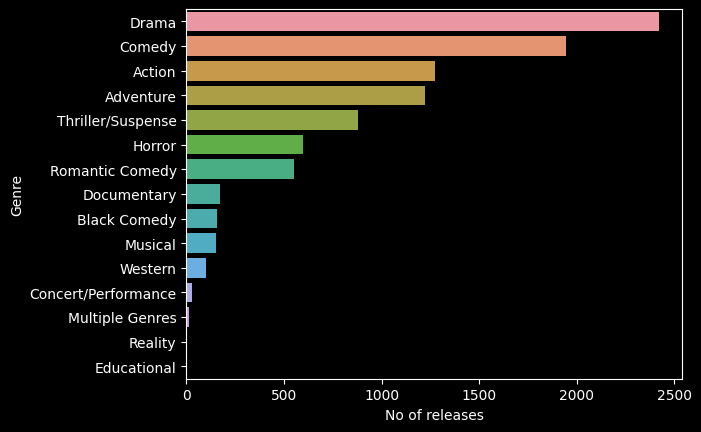

In [27]:
list_genre=data.groupby(['Genre']).size().reset_index(name='No of releases').sort_values(ascending=False,by='No of releases')
sns.barplot(data=list_genre,y='Genre',x='No of releases')
plt.show()

### Trực quan hóa dữ liệu các thể loại quảng cáo và số lượng mỗi loại

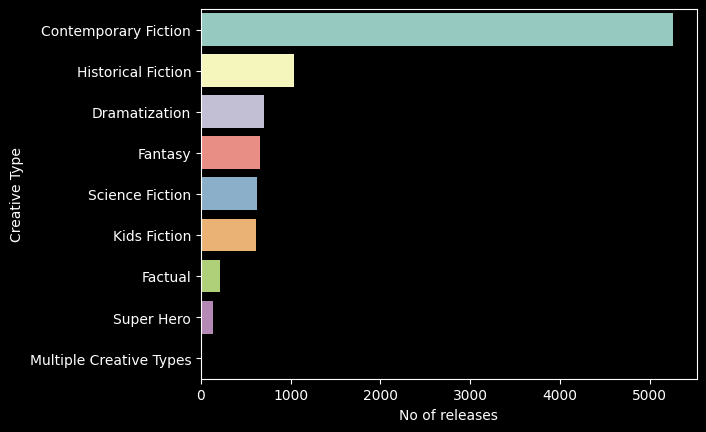

In [28]:
list_creative_type=data.groupby(['Creative Type']).size().reset_index(name='No of releases').sort_values(ascending=False,by='No of releases')
sns.barplot(data=list_creative_type,y='Creative Type',x='No of releases')
plt.show()

### Trực quan hóa dữ liệu các thể loại nhãn phim đối với người xem và số lượng mỗi loại

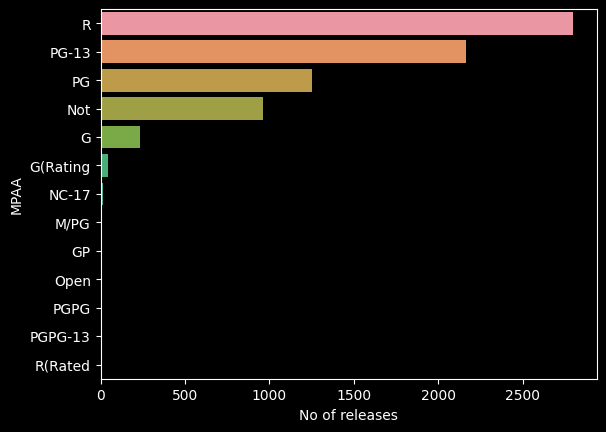

In [29]:
list_mpaa=data.groupby(['MPAA']).size().reset_index(name='No of releases').sort_values(ascending=False,by='No of releases')
sns.barplot(data=list_mpaa,y='MPAA',x='No of releases')
plt.show()

### Trực quan hóa dữ liệu số phim chiếu mỗi ngày của tuần

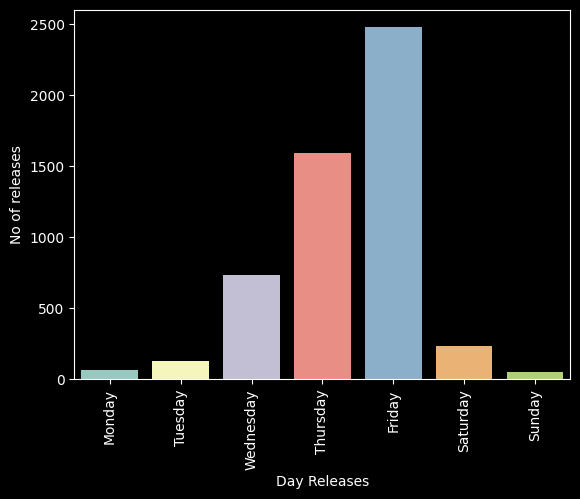

In [30]:
list_day=data.groupby(['Day Releases']).size().reset_index(name='No of releases')
sns.barplot(data=list_day,x='Day Releases',y='No of releases')
plt.gca().set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],rotation='vertical')
plt.show()

### Trực quan hóa dữ liệu số lượng phim của các đạo diễn

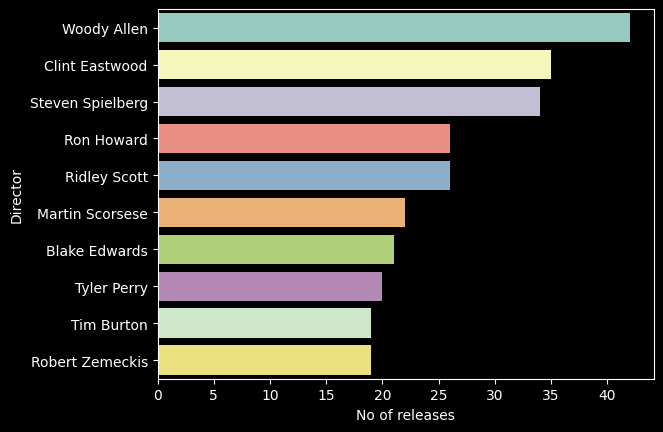

In [31]:
data['Director']=data['Director'].apply(lambda x:[i for i in x.split(',')] if x is not np.nan else [] )
list_director=pd.DataFrame(Counter([i for j in data['Director'] for i in j]).most_common(),columns=['Director','No of releases'])
sns.barplot(data=list_director[:10],y='Director',x='No of releases')
plt.show()

In [32]:

X = data.copy()
y =data[['WorldwideBox Office']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


In [33]:

def total_revenue(df,var,list):
    list_total=[]
    for i in list[var]:
        total=0
        for j in df.index:
            if df.loc[j,var] is np.nan:
                total+=0
            else:
                total+=df.loc[j,'WorldwideBox Office'] if (i in df.loc[j,var]) else 0
        list_total.append(total)   
    list['WorldwideBox Office']=list_total
    return list.sort_values(by='WorldwideBox Office',ascending=False)


In [34]:
list_companies=total_revenue(X_train,'Production/Financing Companies',list_companies)
list_countries=total_revenue(X_train,'Production Countries',list_countries)
list_creative_type=total_revenue(X_train,'Creative Type',list_creative_type)
list_director=total_revenue(X_train,'Director',list_director)
list_franchise=total_revenue(X_train,'Franchise',list_franchise)
list_genre=total_revenue(X_train,'Genre',list_genre)
list_languages=total_revenue(X_train,'Languages',list_languages)
list_mpaa=total_revenue(X_train,'MPAA',list_mpaa)

top100_companies=list_companies[:100].copy()
top100_director=list_director[:100].copy()

top15_franchise=list_franchise[:15].copy()


## Trực quan hóa mối quan hệ giữa doanh thu và các đặc trưng huấn luyện

### Trực quan hóa mỗi quan hệ giữa doanh thu toàn cầu vs các ngày phát hành trong tuần

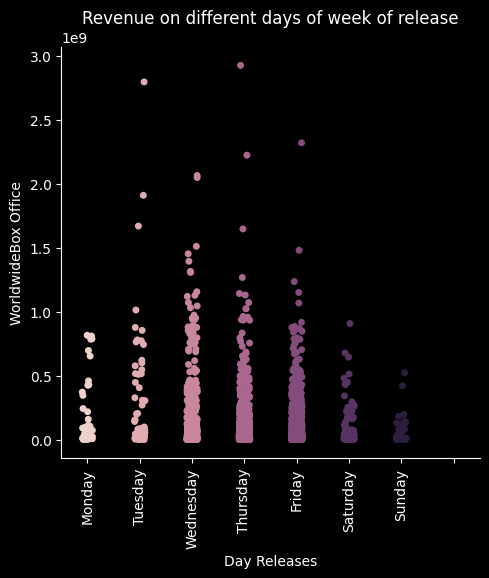

In [35]:
# plt.figure(figsize=(10,10))
sns.catplot(x=X_train['Day Releases'],y=y_train['WorldwideBox Office'], hue=X_train['Day Releases'])
plt.gca().set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],rotation='vertical')
plt.title('Revenue on different days of week of release')
plt.show()

In [36]:
# y_train['WorldwideBox Office']=np.log1p(y_train['WorldwideBox Office'])
# X_train['Production Budget']=np.log1p(X_train['Production Budget'])

### Trực quan hóa mối quan hệ giữa doanh thu toàn cầu vs các tháng trong năm

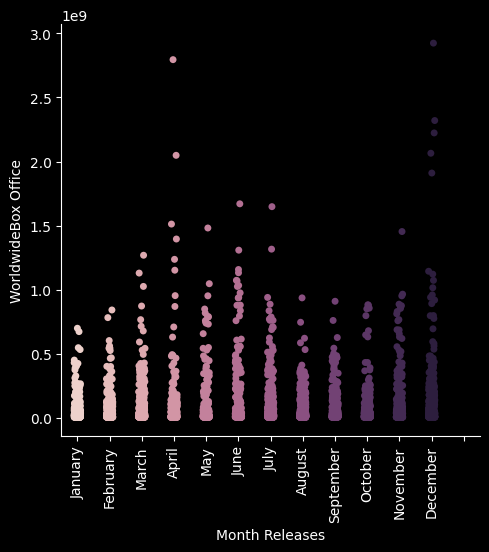

In [37]:
sns.catplot(x=X_train['Month Releases'],y=y_train['WorldwideBox Office'], hue=X_train['Month Releases'])
plt.gca().set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July',
              'August', 'September', 'October', 'November', 'December'],rotation='vertical')
plt.show()

### Trực quan hóa mối quan hệ giữa vốn đầu tư và doanh thu toàn cầu theo 3 mô hình: biểu đồ phân tán, boxplot, bar

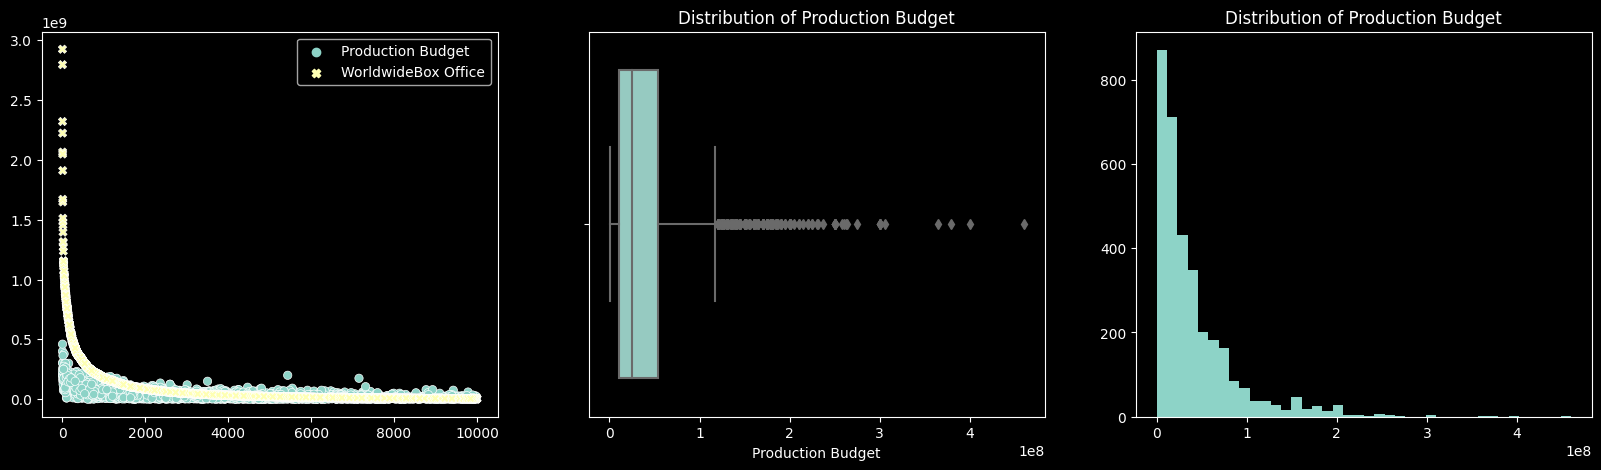

In [38]:

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.scatterplot(data=[X_train['Production Budget'],y_train['WorldwideBox Office']])
plt.subplot(1,3,2)
sns.boxplot(data=X_train,x='Production Budget')
plt.title('Distribution of Production Budget')
plt.subplot(1, 3, 3)
plt.hist(X_train['Production Budget'], bins=40)
plt.title('Distribution of Production Budget')
plt.show()


### Trực quan hóa mối quan hệ thời gian vs doanh thu toàn cầu

Text(0.5, 1.0, 'Running Time vs WorldwideBox Office')

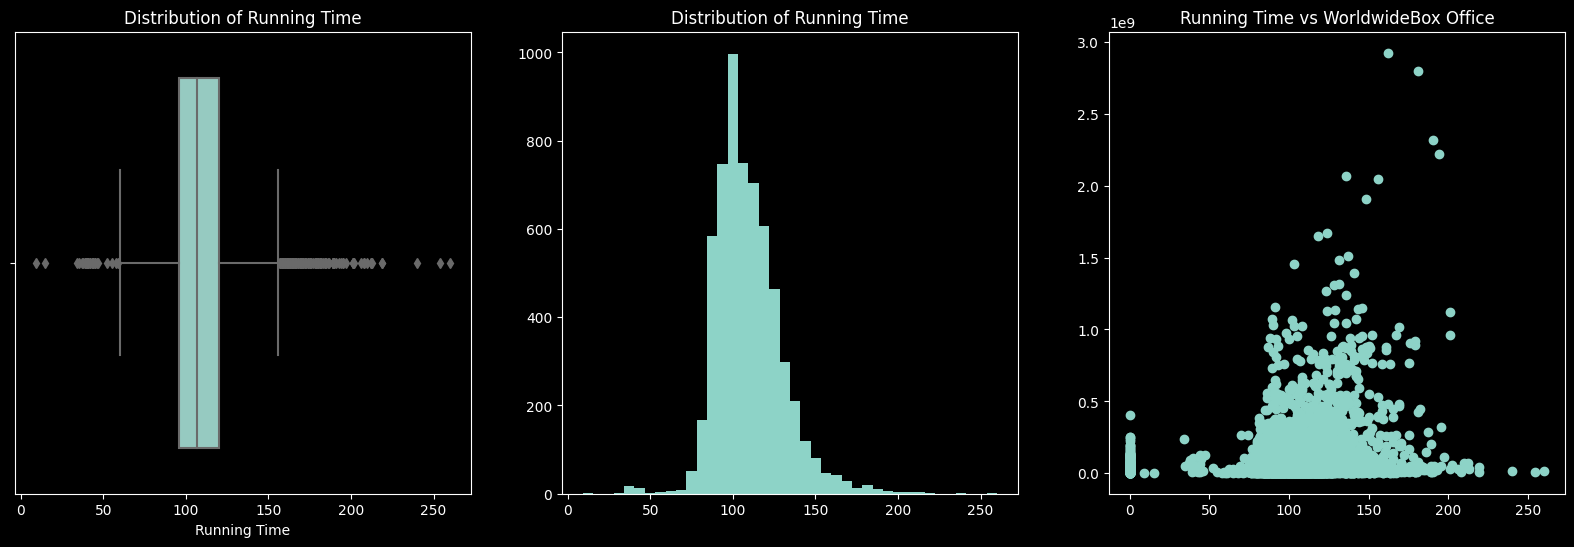

In [39]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
sns.boxplot(data=X_train,x='Running Time')
plt.title('Distribution of Running Time')
plt.subplot(1, 3, 2)
plt.hist(X_train['Running Time'], bins=40)
plt.title('Distribution of Running Time')
plt.subplot(1, 3, 3)
plt.scatter(X_train['Running Time'].fillna(0), X_train['WorldwideBox Office'])
plt.title('Running Time vs WorldwideBox Office')

### Trực quan hóa mối quan hệ giữa doanh thu toàn cầu vs đạo diễn phim.

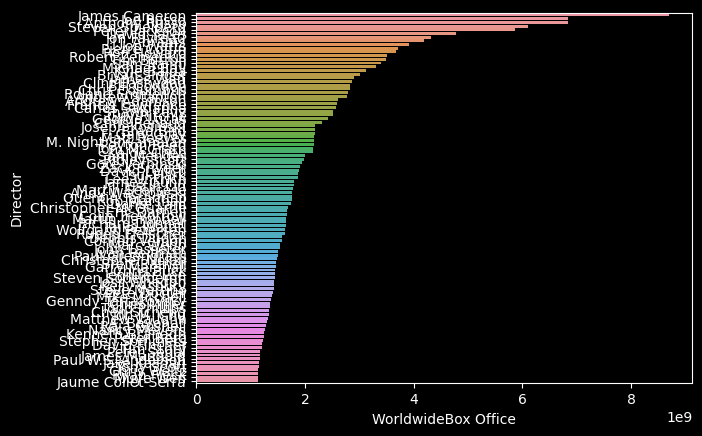

In [40]:
sns.barplot(data=list_director[:100],y='Director',x='WorldwideBox Office')
plt.show()

### Trực quan hóa mối quan hệ giữa doanh thu toàn cầu và nhà sản xuất

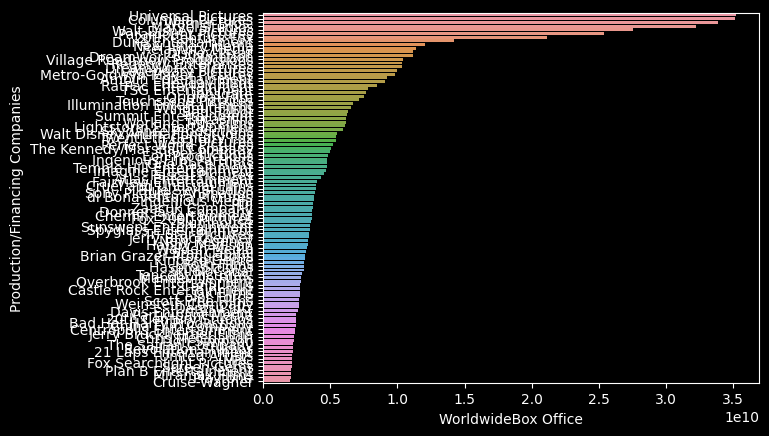

In [41]:
sns.barplot(data=list_companies[:100],y='Production/Financing Companies',x='WorldwideBox Office')
plt.show()

### Trực quan hóa mối quan hệ giữa tên thương mại(tựa phim) và doanh thu toàn cầu

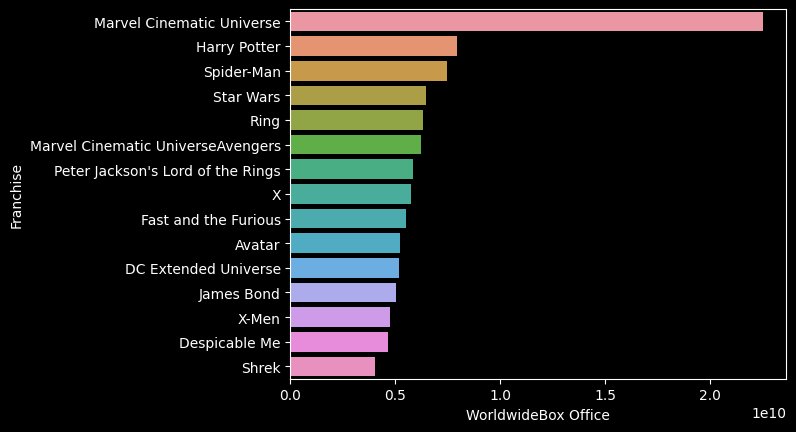

In [42]:
sns.barplot(data=list_franchise[:15],y='Franchise',x='WorldwideBox Office')
plt.show()

### Trực quan hóa mối quan hệ giữa quốc gia phát hành và doanh thu toàn cầu

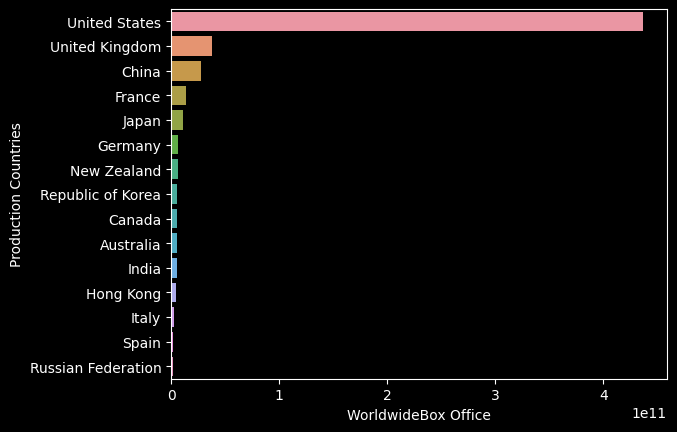

In [43]:
sns.barplot(data=list_countries[:15],y='Production Countries',x='WorldwideBox Office')
plt.show()

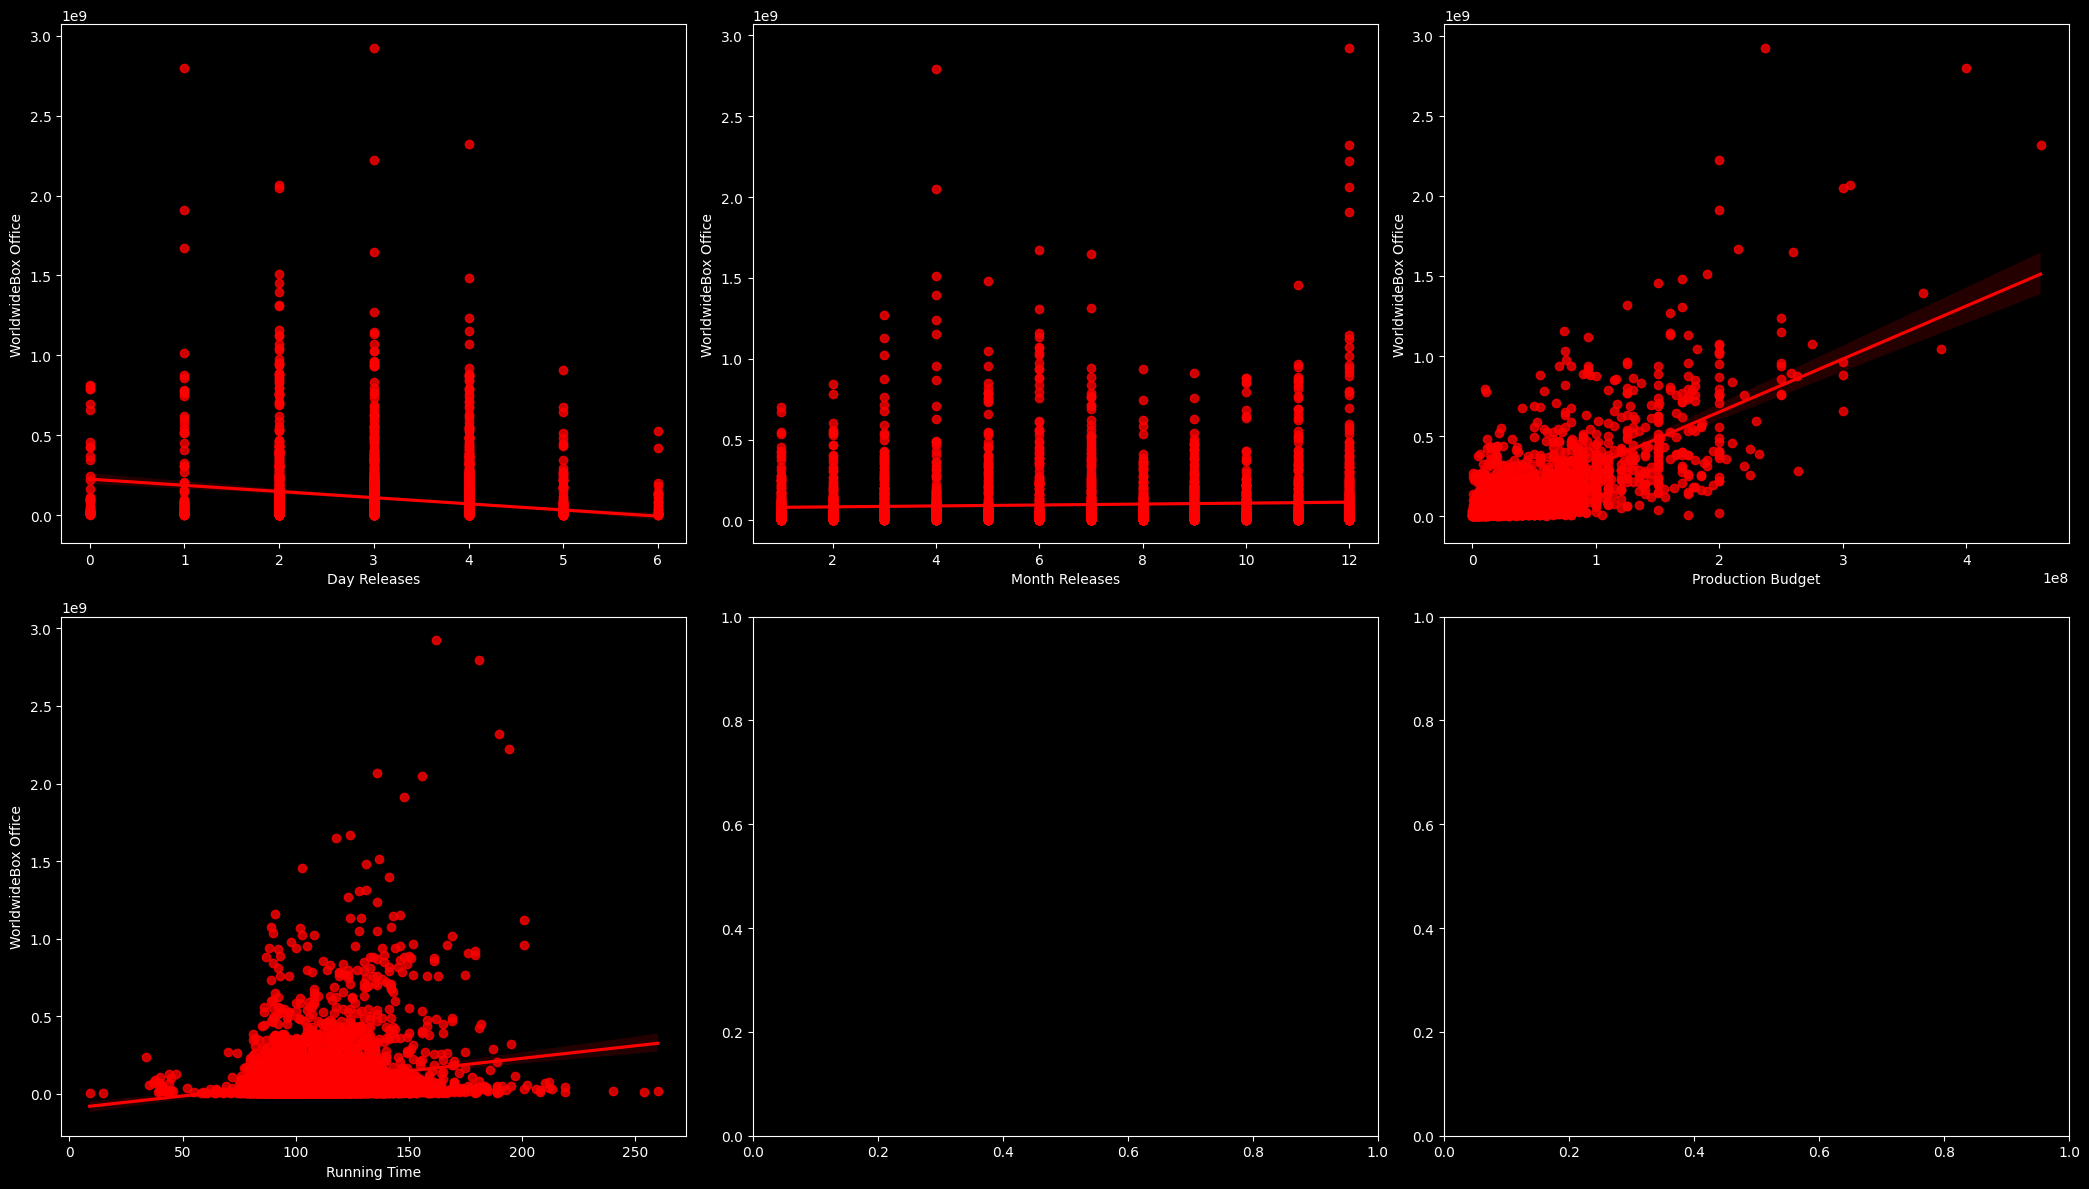

In [44]:
fig, ax = plt.subplots(2, 3, figsize=(21,12))

ax1 = plt.subplot(231)
ax1 = sns.regplot(data=X_train, y='WorldwideBox Office', x='Day Releases', color='red')
ax2 = plt.subplot(232)
ax2 = sns.regplot(data=X_train, y='WorldwideBox Office', x='Month Releases', color='red')
ax3 = plt.subplot(233)
ax3 = sns.regplot(data=X_train, y='WorldwideBox Office', x='Production Budget', color='red')
ax4 = plt.subplot(234)
ax4 = sns.regplot(data=X_train, y='WorldwideBox Office', x='Running Time', color='red')

plt.tight_layout()

In [45]:

def is_holiday_month(df):
    df['holiday_month']=[1 if i in [5,6,7,11,12] else np.nan if i is np.nan else 0 for i in df['Month Releases']]
    return df

def original_isEnglish(df):
    df['origin_isEnglish']=[1 if 'English' in i else 0 for i in df['Languages']]
    return df 

def countries_isUS(df):
    df['countries_isUS']=[1 if 'United States' in i else 0 for i in df['Production Countries']]
    return df

def top_companies(df):
    list=[]
    for i in df['Production/Financing Companies']:
        val=1 if any(x in i for x in top100_companies['Production/Financing Companies']) else np.nan if i is np.nan else 0
        list.append(val)
    df['topCompanies']=list
    return df

def isTop_director(df):
    list=[]
    for i in df['Director']:
        val=1 if any(x in i for x in top100_director['Director']) else np.nan if i is np.nan else 0
        list.append(val)
    df['topDirector']=list
    return df

def top_franchise(df):
    list=[]
    for i in df['Franchise']:
        val=1 if  i in top15_franchise['Franchise'] else 0 if i is np.nan else 2
        list.append(val)
    df['topFranchise']=list
    return df


# Mô hình hóa 

## Big Dataset

In [46]:
metrics_dict_randomforest = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-score': []
}
metrics_dict_logistic = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-score': []
}

In [47]:

def evaluate_params_randomforest(X_train,y_train):
    classifier = RandomForestClassifier()
    # Định nghĩa danh sách các siêu tham số và phân phối tương ứng
    param_dist = {
        'n_estimators': [10, 50, 100],
        'max_depth': [None, 5, 10],
        'min_samples_split': uniform(loc=0, scale=1),
        'min_samples_leaf': uniform(loc=0, scale=0.5)
    }
    random_search = RandomizedSearchCV(estimator=classifier, param_distributions=param_dist, n_iter=10, cv=5)
    random_search.fit(X_train, y_train)
    best_params = random_search.best_params_
    print("Best Parameters: ", random_search.best_params_)
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred)
    # print(accuracy)
    return best_params


In [48]:

def evaluate_model_randomforest(X_train, y_train, X_test, y_test):
    print("\n")
    print("Result Randomforest")
    best_param_randomforest = evaluate_params_randomforest(X_train,y_train)
    n_param = best_param_randomforest['n_estimators']
    md_param = best_param_randomforest['max_depth']
    mss_param = best_param_randomforest['min_samples_split']
    msl_param = best_param_randomforest['min_samples_leaf']

    # classifier = RandomForestClassifier()
    classifier = RandomForestClassifier(n_estimators=n_param,max_depth= md_param,min_samples_split=mss_param,min_samples_leaf=msl_param)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    metrics_dict_randomforest['Accuracy'].append(accuracy_score(y_test, y_pred))
    metrics_dict_randomforest['Precision'].append(precision_score(y_test, y_pred, average='macro'))
    metrics_dict_randomforest['Recall'].append(recall_score(y_test, y_pred, average='macro'))
    metrics_dict_randomforest['F1-score'].append(f1_score(y_test, y_pred, average='macro'))

    return metrics_dict_randomforest,y_pred



In [49]:
def evaluate_params_logistic(X_train, y_train):
    classifier = LogisticRegression()
    # Định nghĩa danh sách các siêu tham số và phân phối tương ứng
    param_dist = {
        'C': uniform(loc=0, scale=4),  # Tham số regularization C
        'penalty': ['l1', 'l2'],  # Loại regularization penalty
        'solver': ['liblinear', 'saga']  # Thuật toán tối ưu hóa
    }
    random_search = RandomizedSearchCV(estimator=classifier, param_distributions=param_dist, n_iter=10, cv=5)
    random_search.fit(X_train, y_train)
    best_params = random_search.best_params_
    print("Best Parameters: ", random_search.best_params_)
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred)
    # print(accuracy)
    return best_params


In [50]:

def evaluate_model_logistic(X_train, y_train, X_test, y_test):
    print("\n")
    print("Result Logistic")
    best_param_logistic = evaluate_params_logistic(X_train, y_train)
    C_param = best_param_logistic['C']
    penalty_param = best_param_logistic['penalty']
    solver_param = best_param_logistic['solver']
    classifier = LogisticRegression(C=C_param,penalty=penalty_param,solver=solver_param)
    # classifier = LogisticRegression()

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    metrics_dict_logistic['Accuracy'].append(accuracy_score(y_test, y_pred))
    metrics_dict_logistic['Precision'].append(precision_score(y_test, y_pred, average='weighted'))
    metrics_dict_logistic['Recall'].append(recall_score(y_test, y_pred, average='weighted'))
    metrics_dict_logistic['F1-score'].append(f1_score(y_test, y_pred, average='weighted'))

    return metrics_dict_logistic,y_pred

In [51]:
X_train=top_companies(X_train)
X_train=isTop_director(X_train)
X_train=is_holiday_month(X_train)
X_train=original_isEnglish(X_train)
X_train=top_franchise(X_train)
X_train=countries_isUS(X_train)

X_test=top_companies(X_test)
X_test=isTop_director(X_test)
X_test=is_holiday_month(X_test)
X_test=original_isEnglish(X_test)
X_test=top_franchise(X_test)
X_test=countries_isUS(X_test)


In [52]:

X_train, X_test = ms_mode(X_train, X_test, 'Running Time')
X_train, X_test = ms_mode(X_train, X_test, 'Genre')
X_train, X_test = ms_mode(X_train,X_test,'Production Budget')
X_train, X_test = ms_mode(X_train,X_test,'Creative Type')
X_train, X_test = ms_mode(X_train,X_test,'Day Releases')
X_train, X_test = ms_mode(X_train,X_test,'Month Releases')
X_train,X_test=ms_mode(X_train,X_test,'MPAA')

In [53]:
X_train = label_encoder(X_train, "Genre")
X_train = label_encoder(X_train, "Creative Type")
X_train=label_encoder(X_train,"MPAA")

X_test = label_encoder(X_test, "Genre")
X_test = label_encoder(X_test, "Creative Type")
X_test=label_encoder(X_test,"MPAA")



In [54]:
X_train=X_train[['Production Budget','MPAA','Running Time','Genre','Creative Type','topCompanies','topDirector','Day Releases','Month Releases','holiday_month','origin_isEnglish','topFranchise','countries_isUS']]
X_test=X_test[['Production Budget','MPAA','Running Time','Genre','Creative Type','topCompanies','topDirector','Day Releases','Month Releases','holiday_month','origin_isEnglish','topFranchise','countries_isUS']]
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 7681 to 2732
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Production Budget  7000 non-null   float64
 1   MPAA               7000 non-null   int64  
 2   Running Time       7000 non-null   float64
 3   Genre              7000 non-null   int64  
 4   Creative Type      7000 non-null   int64  
 5   topCompanies       7000 non-null   int64  
 6   topDirector        7000 non-null   int64  
 7   Day Releases       7000 non-null   float64
 8   Month Releases     7000 non-null   float64
 9   holiday_month      7000 non-null   int64  
 10  origin_isEnglish   7000 non-null   int64  
 11  topFranchise       7000 non-null   int64  
 12  countries_isUS     7000 non-null   int64  
dtypes: float64(4), int64(9)
memory usage: 1023.7 KB


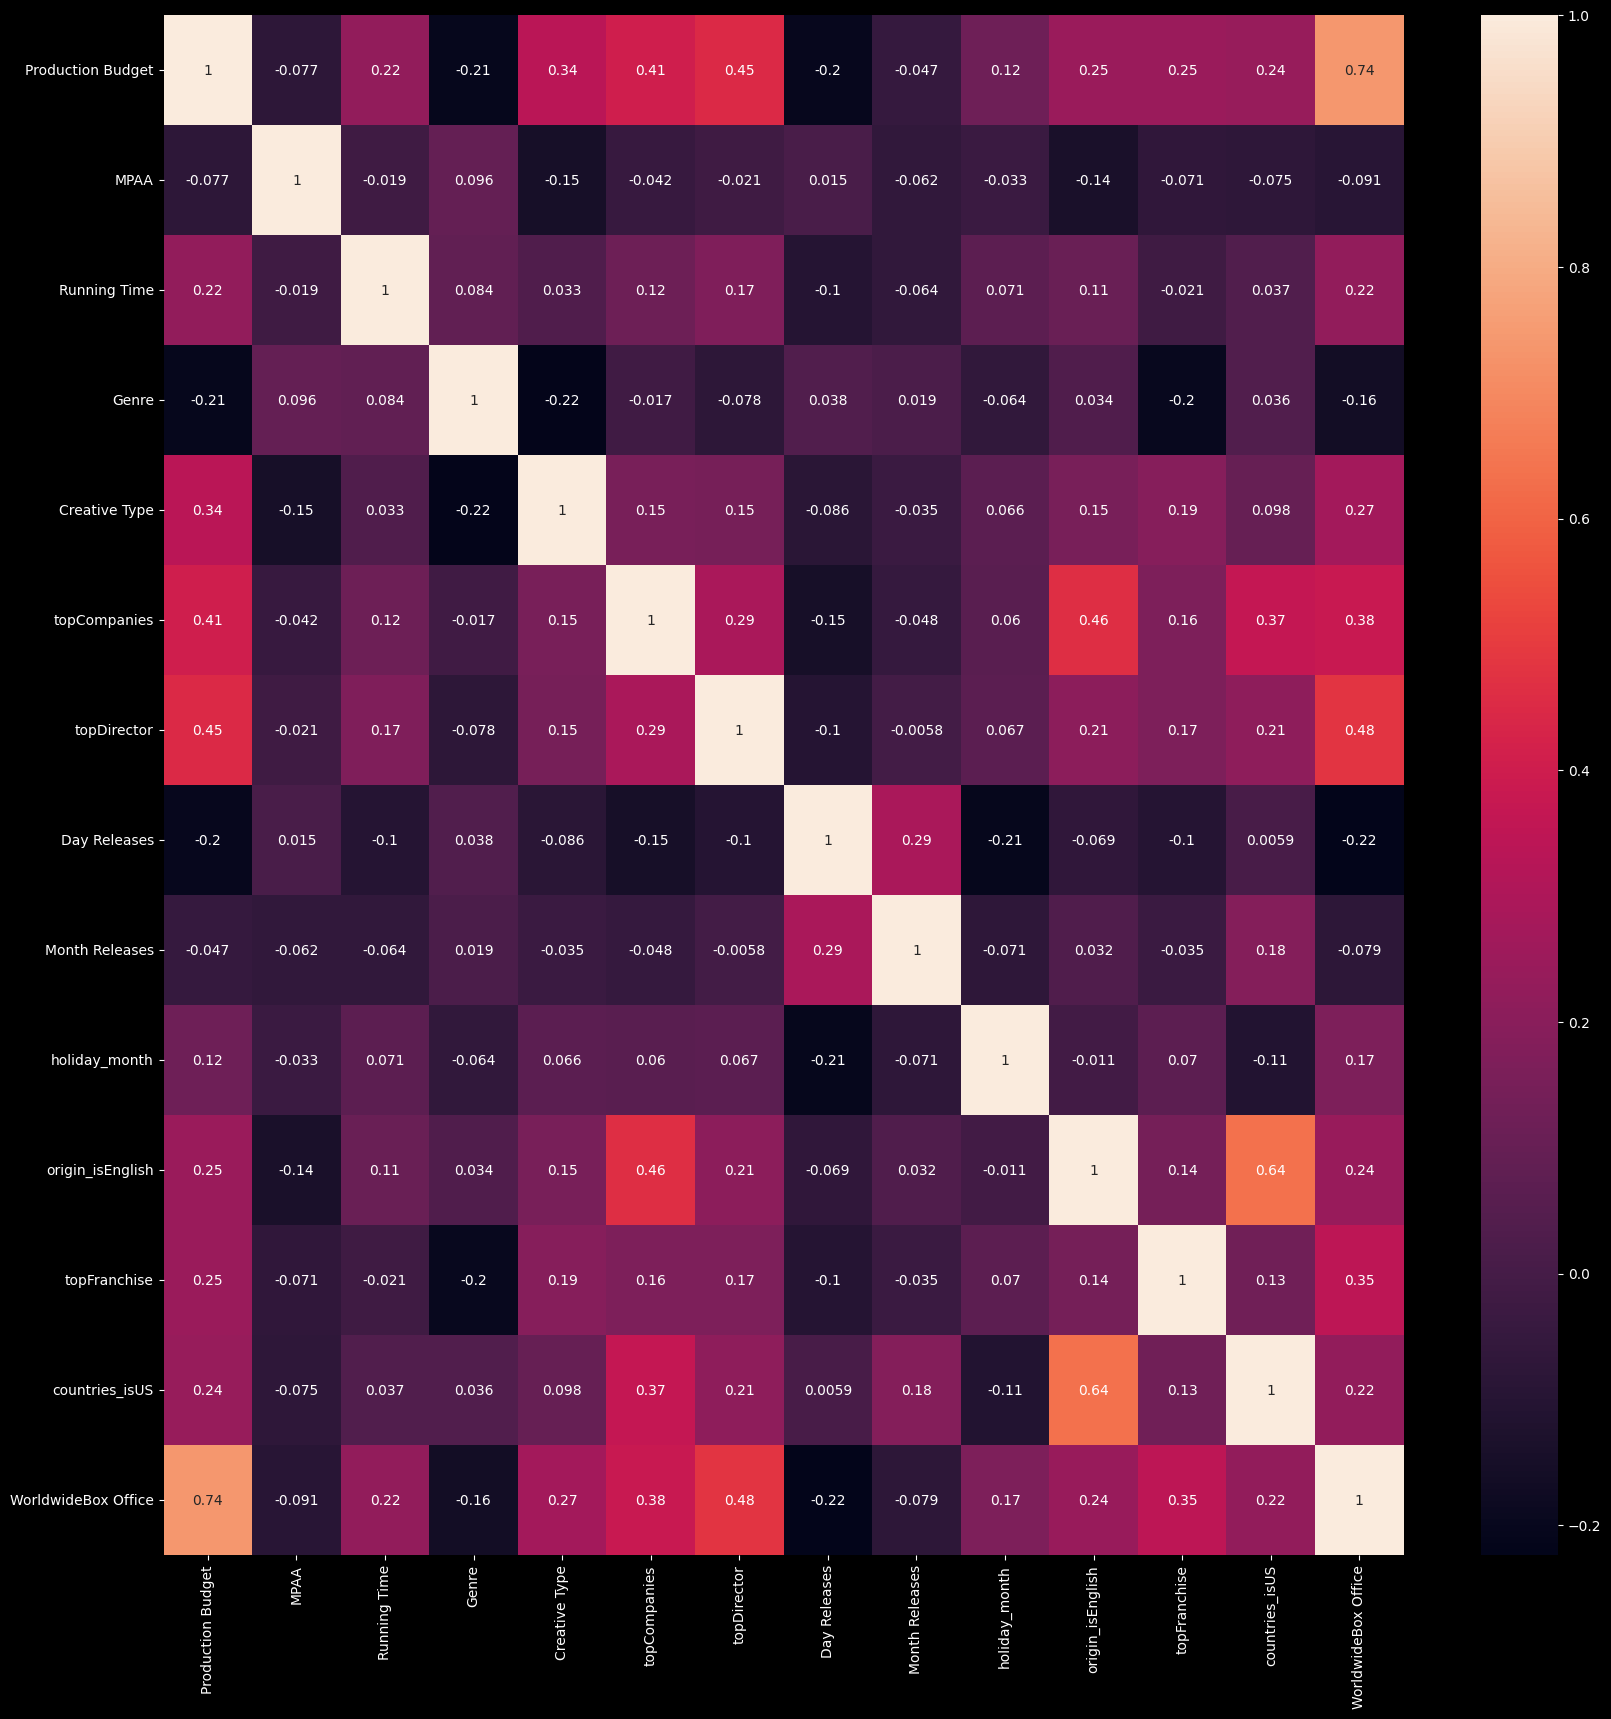

In [55]:
corr=pd.concat([X_train,y_train],axis=1).corr()
plt.figure(figsize=(20, 20))

# plot heatmap
sns.heatmap(corr, annot=True)
plt.show()

In [56]:
corr['WorldwideBox Office'].sort_values(ascending=False)

WorldwideBox Office    1.000000
Production Budget      0.738641
topDirector            0.483282
topCompanies           0.378646
topFranchise           0.347673
Creative Type          0.271140
origin_isEnglish       0.240684
Running Time           0.223872
countries_isUS         0.223435
holiday_month          0.167237
Month Releases        -0.078814
MPAA                  -0.091160
Genre                 -0.161903
Day Releases          -0.223956
Name: WorldwideBox Office, dtype: float64

In [57]:

X_train,X_test = handler_outlier(X_train,X_test,'Running Time')
X_train,X_test = handler_outlier(X_train,X_test,'Production Budget')

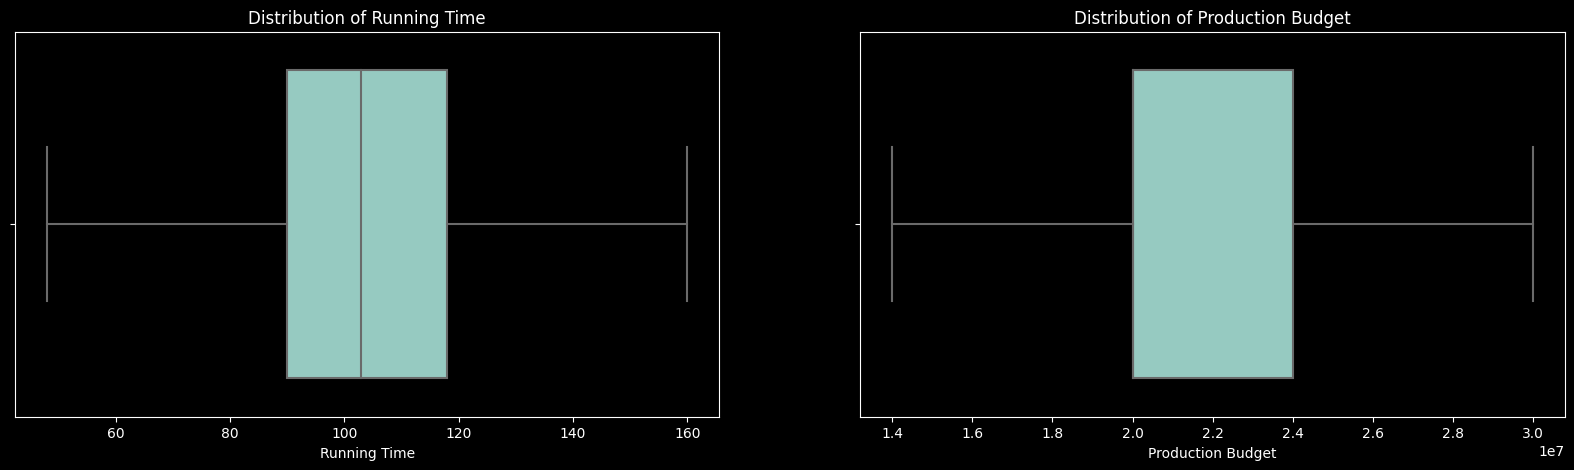

In [58]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=X_train,x='Running Time')
plt.title('Distribution of Running Time')
plt.subplot(1, 2, 2)
sns.boxplot(data=X_train,x='Production Budget')
plt.title('Distribution of Production Budget')
plt.show()

In [59]:

bin_edges=[x for x in range(0,3000000001,300000000)]
bin_labels = [x for x in range(1,len(bin_edges))]

y_train_val = pd.cut(y_train['WorldwideBox Office'], bins=bin_edges, labels=bin_labels)
y_test_val = pd.cut(y_test['WorldwideBox Office'], bins=bin_edges, labels=bin_labels)

metrics_dict_logistic,_=evaluate_model_logistic(X_train,y_train_val,X_test,y_test_val)
metrics_dict_randomforest,_=evaluate_model_randomforest(X_train,y_train_val,X_test,y_test_val)


normal_list = ['Unscaled', 'Standard', 'MinMax', 'MaxAbs', 'Robust', 'PowerTransformer',
               'Normalizer']

X_train_val, X_test_val = normal_data(X_train, X_test, 'Standard')
metrics_dict_logistic,_=evaluate_model_logistic(X_train_val,y_train_val,X_test_val,y_test_val)
metrics_dict_randomforest,_=evaluate_model_randomforest(X_train_val,y_train_val,X_test_val,y_test_val)


k = 7  # Số lượng đặc trưng tốt nhất bạn muốn chọn
selector = SelectKBest(score_func=f_regression, k=k)
selected_features = selector.fit_transform(X_train_val, y_train_val)
feature_indices = selector.get_support(indices=True)
selected_feature_names = X_train_val.columns[feature_indices]
print(selected_feature_names)
X_train_val = X_train_val[selected_feature_names]

metrics_dict_logistic,y_pred_logistic=evaluate_model_logistic(X_train_val,y_train_val,X_test_val[selected_feature_names],y_test_val)
metrics_dict_randomforest,y_pred_randomforest=evaluate_model_randomforest(X_train_val,y_train_val,X_test_val[selected_feature_names],y_test_val)




Result Logistic
Best Parameters:  {'C': 0.7242380274696236, 'penalty': 'l1', 'solver': 'liblinear'}


Result Randomforest
Best Parameters:  {'max_depth': None, 'min_samples_leaf': 0.3215476692134276, 'min_samples_split': 0.22235381434369472, 'n_estimators': 10}


Result Logistic
Best Parameters:  {'C': 1.400865350046737, 'penalty': 'l2', 'solver': 'liblinear'}


Result Randomforest
Best Parameters:  {'max_depth': None, 'min_samples_leaf': 0.4790343328904541, 'min_samples_split': 0.14732150777957664, 'n_estimators': 10}
Index(['Production Budget', 'Running Time', 'Creative Type', 'topCompanies',
       'topDirector', 'Day Releases', 'topFranchise'],
      dtype='object')


Result Logistic
Best Parameters:  {'C': 1.8609718497485912, 'penalty': 'l1', 'solver': 'saga'}


Result Randomforest
Best Parameters:  {'max_depth': 5, 'min_samples_leaf': 0.25257517182993516, 'min_samples_split': 0.9535715486367567, 'n_estimators': 50}


In [60]:

metrics_dict_logistic=pd.DataFrame(metrics_dict_logistic,index=['Outlier','Standard','SelectKBest'])
metrics_dict_logistic

,Accuracy,Precision,Recall,F1-score
Outlier,0.952333,0.936709,0.952333,0.938564
Standard,0.951333,0.930684,0.951333,0.939444
SelectKBest,0.949667,0.931263,0.949667,0.938991


In [61]:
metrics_dict_randomforest=pd.DataFrame(metrics_dict_randomforest,index=['Outlier','Standard','SelectKBest'])
metrics_dict_randomforest


,Accuracy,Precision,Recall,F1-score
Outlier,0.946,0.157667,0.166667,0.162042
Standard,0.946,0.157667,0.166667,0.162042
SelectKBest,0.946,0.157667,0.166667,0.162042


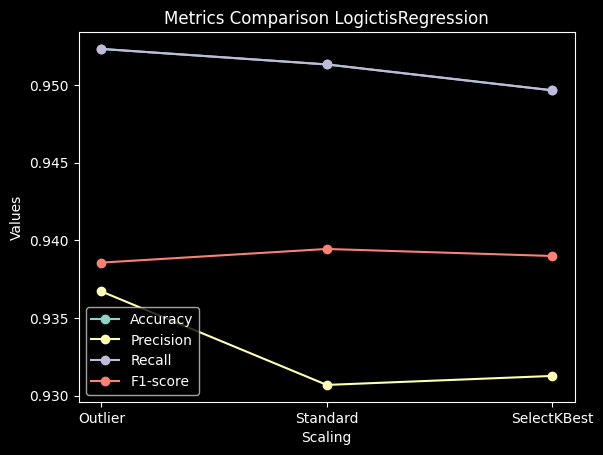

In [62]:
metrics = list(metrics_dict_logistic.keys())

for metric in metrics:
    values = metrics_dict_logistic[metric]
    plt.plot(['Outlier','Standard','SelectKBest'], values, marker='o', label=metric)



plt.title('Metrics Comparison LogictisRegression')
plt.xlabel('Scaling')
plt.ylabel('Values')
plt.legend()
plt.show()

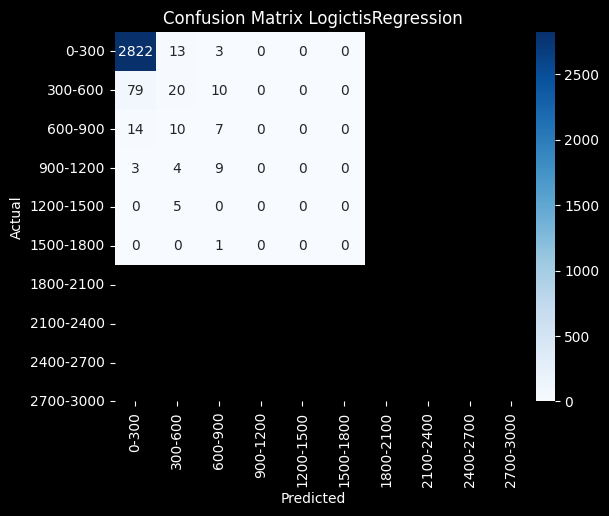

In [63]:
labels=['0-300','300-600','600-900','900-1200','1200-1500','1500-1800','1800-2100','2100-2400','2400-2700','2700-3000']
cm_logictis=confusion_matrix(np.array(y_test_val),y_pred_logistic)
sns.heatmap(cm_logictis, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')

plt.title('Confusion Matrix LogictisRegression')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

**Nhận xét :**

*   Sau khi được xử lý dữ liệu trống và xử lý ngoại lệ giá trị của các metrics là khá cao.
*   Sau khi được chuẩn hóa theo phương pháp Standard thì giá trị của các metrics có sự biến thiên nhưng không đáng kể.
*   Sau khi chọn ra 7 đặc trưng để đánh giá thì giá trị các metrics đều có sự biến thiên nhưng không đáng kể.
*   Kết quả cuối cùng các giá trị của metrics là rất tốt.

**Lý giải :**
*   Tập dữ liệu ban đầu (Big Dataset) : Với dữ liệu 10000 mẫu thì ta thấy mô hình Logistic đã có sự cải tiến rõ rệt về cả 4 metrics. 
*   Điều này cho ta thấy mô hình LogisticRegression có hiệu suất tốt hơn trên tập dữ liệu lớn.

**Kết luận**


*   Với mô hình Logistic Regression cho ta thấy mô hình hình này có khả năng dự đoán đúng rất tốt.
*   Các giá trị của recall, precision, f1-score là tương đối tốt.

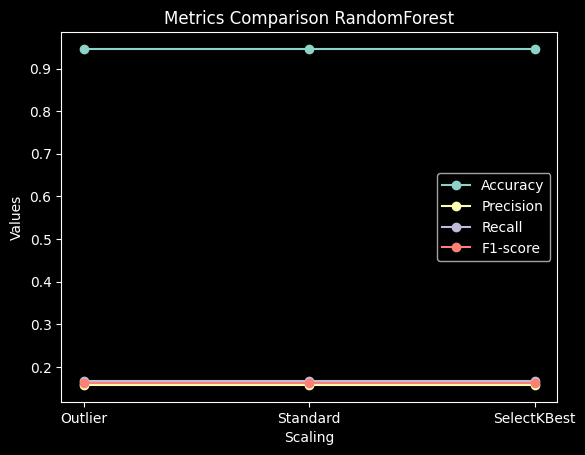

In [64]:
metrics = list(metrics_dict_randomforest.keys())

for metric in metrics:
    values = metrics_dict_randomforest[metric]
    plt.plot(['Outlier','Standard','SelectKBest'], values, marker='o', label=metric)



plt.title('Metrics Comparison RandomForest')
plt.xlabel('Scaling')
plt.ylabel('Values')
plt.legend()
plt.show()

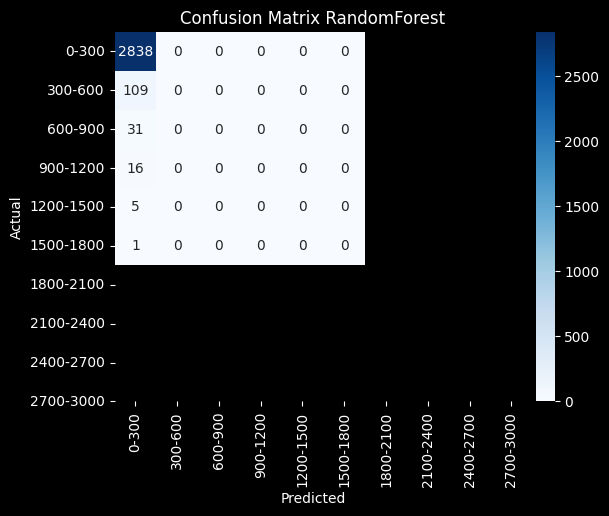

In [65]:
cm_logictis=confusion_matrix(np.array(y_test_val),y_pred_randomforest)
sns.heatmap(cm_logictis, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')

plt.title('Confusion Matrix RandomForest')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

**Nhận xét :**

*   Sau khi được xử lý dữ liệu trống và xử lý ngoại lệ giá trị của các metrics precision, recall, f1-score còn khá thấp.
*   Sau khi được chuẩn hóa theo phương pháp Standard thì giá trị của các metrics không có sự thay đổi đáng kể nào.
*   Sau khi chọn ra 7 đặc trưng để đánh giá thì giá trị các metrics không có sự thay đổi đáng kể nào.

**Lý giải :**

*   Mô hình gặp khó khăn trong việc tìm ra các mẫu positive trong tập dữ liệu. Điều này có thể dẫn đến việc bỏ sót nhiều trường hợp positive và có tỷ lệ false negative cao.
*   Mô hình có xu hướng phân loại nhiều mẫu thành positive mặc dù thực tế là negative. Điều này dẫn đến tỷ lệ false positive cao và khả năng phân loại sai các mẫu negative.

**Kết luận**

*   Với mô hình RandomForestClassifier cho ta thấy mô hình hình này có khả năng dự đoán đúng .
*   Các giá trị của recall, precision, f1-score là còn rất thấp.
*   => Mô hình này chưa phù hợp để đánh giá cho bài toán.

**Kết luận chung** : Bài toán dự đoán mức doanh thu phim với tập Small Dataset(10000 mẫu) sử dụng mô hình LogisticRegression sẽ phù hợp hơn RandomForestClassifier.